<h1 style="font-family:Impact,Arial;font-size:30px;">37011 Financial Market Instrument - Autumn 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 1</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


# Import packages


In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Import data


In [2]:
def data_processing():
    df = pd.read_excel("RBAbondyields.xlsx", header=10)
    df = df.rename(
        columns={
            "Series ID": "Date",
            "FCMYGBAG2D": "Bond 2",
            "FCMYGBAG3D": "Bond 3",
            "FCMYGBAG5D": "Bond 5",
            "FCMYGBAG10D": "Bond 10",
        }
    )

    df["Date"] = pd.to_datetime(df["Date"])

    df[["Bond 2", "Bond 3", "Bond 5", "Bond 10"]] = df[
        ["Bond 2", "Bond 3", "Bond 5", "Bond 10"]
    ].astype(float)
    df.dropna(inplace=True)
    df.interpolate(method="linear", inplace=True)
    df.reset_index(drop=True, inplace=True)
    maturity = pd.DataFrame(
        {
            "Date": df["Date"].copy(),
        }
    )

    for i in [2, 3, 5, 10]:

        maturity[f"Bond {i}"] = maturity["Date"] + pd.DateOffset(years=i)
    return df, maturity


df, maturity = data_processing()

In [3]:
def coupon_date_generation(today, maturity):
    date = today + pd.DateOffset(months=6)
    coupon_dates = []
    while date <= maturity:
        coupon_dates.append(date)
        date += pd.DateOffset(months=6)
    return coupon_dates


def log_linear_interpolation(x, x1, x2, y1, y2):
    return y1 * (y2 / y1) ** ((x - x1).days / (x2 - x1).days)


def discount_factor_stripping(date, current_term_structure):
    T1 = list(filter(lambda x: x[0] < date, current_term_structure))[-1]
    T2 = list(filter(lambda x: x[0] >= date, current_term_structure))[0]
    return log_linear_interpolation(date, T1[0], T2[0], T1[1], T2[1])


def reverse_coupon_date_generation(today, maturity):
    date = maturity
    coupon_dates = []
    while date > today + pd.DateOffset(days=7):
        coupon_dates.append(date)
        date -= pd.DateOffset(months=6)
    return coupon_dates[::-1]


def solver(vars, a1: float, b1: float, c1: float, a2: float, b2: float, c2: float):
    x, y = vars
    eq1 = a1 * x + b1 * y - c1
    eq2 = a2 * x + b2 * y - c2
    return [eq1, eq2]


def solver3(
    vars,
    a1: float,
    b1: float,
    c1: float,
    d1: float,
    a2: float,
    b2: float,
    c2: float,
    d2: float,
    a3: float,
    b3: float,
    c3: float,
    d3: float,
):
    x, y, z = vars
    eq1 = a1 * x + b1 * y + c1 * z - d1
    eq2 = a2 * x + b2 * y + c2 * z - d2
    eq3 = a3 * x + b3 * y + c3 * z - d3
    return [eq1, eq2, eq3]

# Question 1


Log-linear Interpolation:

$$
ln(B(0, T)) = ln(B(0, T_1)) + \frac{T - T_1}{T_2 - T_1} \cdot (ln(B(0, T_2)) - ln(B(0, T_1)))
$$


Assumptions:

- These bonds are semi-annual coupon bond.
- These bonds are hypothetically issued at the day it being asessed.
- These yields are yields to maturity of these bonds.
- The coupon rate is taken as same as the yields rate. So the bond is at par, which means that the price of the bond equal to the face value of it


So as to solve for the discount factor, we just need to use the log-linear interpolation combine with the present value of the bond:

$$
\sum_{i=1}^{n} \frac{y}{2} \cdot B(0,T_i) + B(0,T_n) = 1
$$


In [4]:
def Question_1(df, maturity):
    term_structure = pd.DataFrame(
        {
            "Date": maturity["Date"].copy(),
            "2 year": np.nan,
            "3 year": np.nan,
            "5 year": np.nan,
            "10 year": np.nan,
        }
    )
    for i in range(len(term_structure)):
        today = maturity.iloc[i, 0]
        for j in range(4):
            current_term_time = list(maturity.iloc[i, 0 : j + 2])
            y = df.iloc[i, j + 1] / 100

            def solver(x, coupon_dates):
                current_term_structures = list(term_structure.iloc[i, 1 : j + 1])
                current_term_structures = [1] + current_term_structures + [x[0]]
                current_term_structures = [
                    [current_term_time[k], current_term_structures[k]]
                    for k in range(len(current_term_structures))
                ]
                discount_factors = list(
                    map(
                        lambda x: discount_factor_stripping(x, current_term_structures),
                        coupon_dates,
                    )
                )
                return sum(discount_factors) * y / 2 + discount_factors[-1] - 1

            maturity_date = maturity.iloc[i, j + 1]
            coupon_dates = coupon_date_generation(today, maturity_date)
            term_structure.iloc[i, j + 1] = fsolve(solver, 1, args=(coupon_dates))[0]
    return term_structure


term_structure = Question_1(df, maturity)

In [5]:
term_structure

,Date,2 year,3 year,5 year,10 year
0,2013-09-02,0.949757,0.919803,0.849632,0.667166
1,2013-09-03,0.948670,0.918251,0.847366,0.664524
2,2013-09-04,0.947510,0.916397,0.844816,0.663137
3,2013-09-05,0.946800,0.915226,0.843189,0.659661
4,2013-09-06,0.946090,0.914169,0.841383,0.654747
...,...,...,...,...,...
2544,2024-02-29,0.928312,0.895840,0.829357,0.660867
2545,2024-03-01,0.928138,0.895590,0.829060,0.660616
2546,2024-03-04,0.928721,0.896379,0.830280,0.663311
2547,2024-03-05,0.928721,0.896379,0.830410,0.664027


# Question 2


Assumptions:

- These bond have semi-annual coupons
- Only dates that has data in the dataset will be evaluated
- The date 29th February of any years that have it, the zero bonds with maturity in the year that does not have the date 29th Febraury will be considered matures at 1st March of the year it matures
- If the next coupon payment is less than or equal to 7 days, then that coupon will not be received


In [6]:
def Question_2_process():
    bond = pd.DataFrame(
        {
            "Bond": ["B1", "B2", "B3", "B4"],
            "Maturity": ["2025-03-06", "2026-03-06", "2028-03-06", "2029-03-06"],
            "Coupon": [0.0325, 0.045, 0.005, 0.0125],
        }
    )
    bond["Maturity"] = pd.to_datetime(bond["Maturity"])
    return bond


bond = Question_2_process()

In [7]:
def Question_2(term_structure):
    start_date = pd.to_datetime("2019-03-07")
    end_date = pd.to_datetime("2024-03-06")
    filtered_term_structure = term_structure[term_structure["Date"] >= start_date]
    filtered_term_structure = filtered_term_structure[
        filtered_term_structure["Date"] <= end_date
    ]
    filtered_term_structure.reset_index(drop=True, inplace=True)
    filtered_maturity = maturity[maturity["Date"] >= start_date]
    filtered_maturity = filtered_maturity[filtered_maturity["Date"] <= end_date]
    filtered_maturity.reset_index(drop=True, inplace=True)
    bond_price = pd.DataFrame(
        {
            "Date": filtered_term_structure["Date"].copy(),
            "B1": np.nan,
            "B2": np.nan,
            "B3": np.nan,
            "B4": np.nan,
        }
    )
    for i in range(len(bond_price)):
        current_term_time = list(filtered_maturity.iloc[i, :])
        for j in range(4):
            today = bond_price.iloc[i, 0]
            maturity_date = bond.iloc[j, 1]
            coupon = bond.iloc[j, 2]
            coupon_dates = reverse_coupon_date_generation(today, maturity_date)
            current_term_structures = list(filtered_term_structure.iloc[i, 1:])
            current_term_structures = [1] + current_term_structures
            current_term_structures = [
                [current_term_time[k], current_term_structures[k]]
                for k in range(len(current_term_structures))
            ]
            discount_factors = list(
                map(
                    lambda x: discount_factor_stripping(x, current_term_structures),
                    coupon_dates,
                )
            )
            bond_price.iloc[i, j + 1] = (
                sum(discount_factors) * coupon / 2 + discount_factors[-1]
            )
    return bond_price


bond_price = Question_2(term_structure)

In [8]:
bond_price

,Date,B1,B2,B3,B4
0,2019-03-07,1.081234,1.169698,0.873002,0.924583
1,2019-03-08,1.083697,1.172973,0.877108,0.929387
2,2019-03-11,1.083679,1.172982,0.877184,0.929489
3,2019-03-12,1.083668,1.172942,0.877095,0.929374
4,2019-03-13,1.087655,1.177854,0.882517,0.935566
...,...,...,...,...,...
1248,2024-02-29,0.994486,1.013640,0.879773,0.885214
1249,2024-03-01,0.994494,1.013554,0.879587,0.885013
1250,2024-03-04,0.995110,1.014471,0.880893,0.886608
1251,2024-03-05,0.995211,1.014569,0.881053,0.886847


# Question 3


Assumption:

- Only dates that have data in the dataset will be evaluated
- The dates that don't have data will be assessed at the dates closest to the those dates


In order to calculate the hypothetical yield to maturity for each bond, we solve for y in the following formula:

$$
P = \frac{1}{(1+\frac{y}{2})^{\frac{d_{TN}}{d_{PN}}}}(\frac{c}{2}(x+\frac{1-(1+\frac{y}{2})^{1-n}}{\frac{y}{2}})+\frac{1}{(1+\frac{y}{k})^{n-1}})
$$

The modified duration:

$$
D_{mod} = \frac{D_{Mac}}{1+\frac{y}{2}} = \frac{\sum_{j=1}^{n} T_jC_j\hat{B}(0,T_j)}{(1+\frac{y}{2})(\sum_{j=1}^{n} C_j\hat{B}(0,T_j))}
$$

The modified convexity:

$$
C_{mod} = \frac{C_{Mac}}{(1+\frac{y}{2})^2} = \frac{\sum_{j=1}^{n} T_j(T_j+1)C_j\hat{B}(0,T_j)}{(1+\frac{y}{2})^2(\sum_{j=1}^{n} C_j\hat{B}(0,T_j))}
$$


Calculate modified duration and modified convexity for each bond:


Function definition:


In [9]:
def coupon_date_finder(today, maturity):
    checkdate = pd.to_datetime(maturity)
    coupon_dates = []
    while checkdate >= today:
        coupon_dates.append(checkdate)
        checkdate -= pd.DateOffset(months=6)
    next_coupon_date = coupon_dates[-1]
    w = (next_coupon_date - today).days / (next_coupon_date - checkdate).days
    x = 1 if (next_coupon_date - today).days > 7 else 0
    n = (
        len(coupon_dates)
        if (next_coupon_date - today).days > 0
        else len(coupon_dates) - 1
    )
    return w, n, x, coupon_dates[::-1]


def aofm_optimizer(y: float, coupon: float, price: float, n: int, w: float, x: int):
    i = y / 2
    sum = (100 / ((1 + i) ** w)) * (
        (coupon / 2) * (x + (1 - (1 + i) ** (1 - n)) / i) + 1 / ((1 + i) ** (n - 1))
    )
    return price - sum


def year_transform(today, date):
    year = 0
    check_date = today
    while check_date <= date:
        year += 1
        check_date += pd.DateOffset(years=1)
    year += (check_date - pd.DateOffset(years=1) - date).days / (
        check_date - (check_date - pd.DateOffset(years=1))
    ).days
    return year

Calculation:


In [10]:
def Question_3_process():
    # Bond information
    bond_info = pd.DataFrame(
        {
            "Date": bond_price["Date"].copy(),
            "B1 duration": np.nan,
            "B1 convexity": np.nan,
            "B2 duration": np.nan,
            "B2 convexity": np.nan,
            "B3 duration": np.nan,
            "B3 convexity": np.nan,
            "B4 duration": np.nan,
            "B4 convexity": np.nan,
        }
    )
    for i in range(len(bond_info)):

        for j in range(len(bond)):

            today = bond_info.iloc[i, 0]

            bond_maturity = bond.iloc[j, 1]

            coupon = bond.iloc[j, 2]

            price = bond_price.iloc[i, j + 1]

            w, n, x, coupon_dates = coupon_date_finder(today, bond_maturity)

            y = fsolve(aofm_optimizer, x0=0.3, args=(coupon, price, n, w, x))[0]
            t = list(map(lambda x: year_transform(today, x), coupon_dates))

            t = np.array(t)
            B = 1 / np.power(1 + y / 2, 2 * t)
            bond_info.iloc[i, j * 2 + 1] = (
                coupon * np.sum(B * t) / 2 + t[-1] * B[-1]
            ) / ((coupon * np.sum(B) / 2 + B[-1]) * (1 + y / 2))

            bond_info.iloc[i, j * 2 + 2] = (
                coupon * np.sum(B * t * (t + 1)) / 2 + t[-1] * (t[-1] + 1) * B[-1]
            ) / ((coupon * np.sum(B) / 2 + B[-1]) * ((1 + y / 2) ** 2))

    # Liability information
    start_date = pd.to_datetime("2019-03-07")
    endLiabilityDate = pd.to_datetime("2027-03-06")
    end_date = pd.to_datetime("2024-03-06")
    liability_value = 100000000
    liability = pd.DataFrame(
        {
            "Date": bond_info["Date"].copy(),
            "Present Value": np.nan,
            "Duration": np.nan,
            "Convexity": np.nan,
        }
    )
    filtered_term_structure = term_structure[term_structure["Date"] >= start_date]
    filtered_term_structure = filtered_term_structure[
        filtered_term_structure["Date"] <= end_date
    ]
    filtered_term_structure.reset_index(drop=True, inplace=True)
    filtered_maturity = maturity[maturity["Date"] >= start_date]
    filtered_maturity = filtered_maturity[filtered_maturity["Date"] <= end_date]
    filtered_maturity.reset_index(drop=True, inplace=True)
    for i in range(len(liability)):
        current_term_time = list(filtered_maturity.iloc[i, :])
        current_term_structures = list(filtered_term_structure.iloc[i, 1:])
        current_term_structures = [1] + current_term_structures
        current_term_structures = [
            [current_term_time[k], current_term_structures[k]]
            for k in range(len(current_term_structures))
        ]
        discount_factor = discount_factor_stripping(
            endLiabilityDate, current_term_structures
        )
        t = year_transform(liability.iloc[i, 0], endLiabilityDate)
        liability.iloc[i, 1] = liability_value * discount_factor
        liability.iloc[i, 2] = t * discount_factor
        liability.iloc[i, 3] = t * (t + 1) * (discount_factor**2)

    return bond_info, liability


bond_info, liability = Question_3_process()

According to the hedge:

$$
PV(Bond_1) * n_1 + PV(Bond_4) * n_4 = PV(liability)
$$

$$
=> n_1 * \frac{PV(Bond_1)}{PV(liability)} + n_4 * \frac{PV(Bond_4)}{PV(liability)} = 1
$$

And:

$$
D_{Mod_{Portfolio}} - D_{Mod_{liability}} = 0
$$

$$
=> D_{Mod_1} \cdot \omega _1 + D_{Mod_4} \cdot \omega _4 = D_{Mod_{liability}}
$$

$$
=> n_1 * D_{Mod_1} \frac{PV(Bond_1)}{PV(liability)} + n_4 * D_{Mod_4} \frac{PV(Bond_4)}{PV(liability)} = D_{liability}
$$

- PV(): return present value of an instrument
- Vi: Value of Bond i
- ni: number of Bond i

This must be maintain after each rebalance

The payoff (profit/loss) before each rebalacing is calculated as:

$$
Payoff = n_{1_{old}} * PV(Bond_1)_{new}  n_{4_{old}} * PV(Bond_4)_{new} - PV(liability)


We have

$$
C_{Mod_{Portfolio}} - C_{Mod_{liability}} = 0
$$

$$
=> C_{Mod_1} \cdot \omega _1 + C_{Mod_4} \cdot \omega _4 = C_{Mod_{liability}}
$$

$$
=> n_1 * C_{Mod_1} \frac{PV(Bond_1)}{PV(liability)} + n_4 * C_{Mod_4} \frac{PV(Bond_4)}{PV(liability)} = C_{liability}
$$


In [11]:
def Question_3(isMonthly, bond_1, bond_2, bond_3=None):
    check_date = pd.to_datetime("2019-03-07")
    real_check_date = pd.to_datetime(check_date)
    end_date = pd.to_datetime("2024-03-06")
    payoff = []
    assessing_date = []
    position = None
    price = None
    while check_date <= end_date:
        assessing_date.append(check_date)
        index = bond_price[bond_price["Date"] == check_date].index[0]
        PL = liability.iloc[index, 1]
        DL = liability.iloc[index, 2]
        P1 = bond_price.iloc[index, bond_1]
        P2 = bond_price.iloc[index, bond_2]
        D1 = bond_info.iloc[index, (bond_1 - 1) * 2 + 1]
        D2 = bond_info.iloc[index, (bond_2 - 1) * 2 + 1]
        solution = None
        if bond_3 is not None:
            C1 = bond_info.iloc[index, (bond_1 - 1) * 2 + 2]
            C2 = bond_info.iloc[index, (bond_2 - 1) * 2 + 2]
            CL = liability.iloc[index, 3]
            P3 = bond_price.iloc[index, bond_3]
            D3 = bond_info.iloc[index, (bond_3 - 1) * 2 + 1]
            C3 = bond_info.iloc[index, (bond_3 - 1) * 2 + 2]
            solution = fsolve(
                solver3,
                [100000, 100000, 100000],
                args=(
                    P1,
                    P2,
                    P3,
                    PL,
                    D1 * P1,
                    D2 * P2,
                    D3 * P3,
                    DL * PL,
                    C1 * P1,
                    C2 * P2,
                    C3 * P3,
                    CL * PL,
                ),
            )
            price = np.array([P1, P2, P3])
        else:
            solution = fsolve(
                solver, [100000, 100000], args=(P1, P2, PL, D1 * P1, D2 * P2, DL * PL)
            )
            price = np.array([P1, P2])
        if abs(np.dot(price, np.array(solution)) - PL) > 1:
            print("Error")
        if position is None:
            payoff.append(PL)
        else:
            payoff.append(np.dot(price, position) - PL)
        position = np.array(solution)
        if check_date == end_date:
            break
        if not isMonthly:
            check_date = bond_price.iloc[index + 1, 0]
            if check_date > end_date:
                check_date = end_date
            real_check_date = pd.to_datetime(check_date)
        else:
            real_check_date += pd.DateOffset(months=1)
            lower_date = list(
                filter(lambda x: x < real_check_date, list(bond_price["Date"]))
            )[-1]
            upper_date = list(
                filter(lambda x: x >= real_check_date, list(bond_price["Date"]))
            )
            if len(upper_date) == 0:
                check_date = lower_date
            else:
                upper_date = upper_date[0]
                if real_check_date - lower_date < upper_date - real_check_date:
                    check_date = lower_date
                else:
                    check_date = upper_date
                if check_date > end_date:
                    check_date = end_date
            real_check_date = pd.to_datetime(check_date)
    return payoff, assessing_date

a/


In [12]:
payoff, assessing_date = Question_3(True, 1, 4)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 1117842.319361508
Standard Deviation of payoff from rebalancing: 13308159.41871567


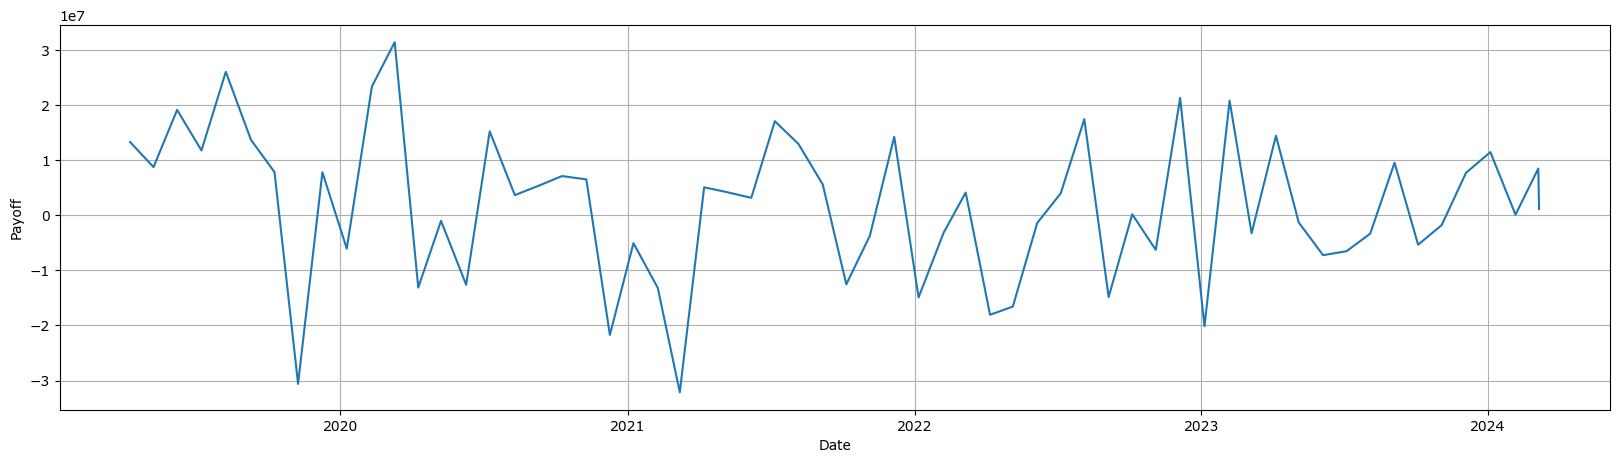

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

b/


Payoff from rebalancing in 6/3/2024:


In [14]:
payoff, assessing_date = Question_3(False, 1, 4)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 1117842.319361508
Standard Deviation of payoff from rebalancing: 3867756.155440782


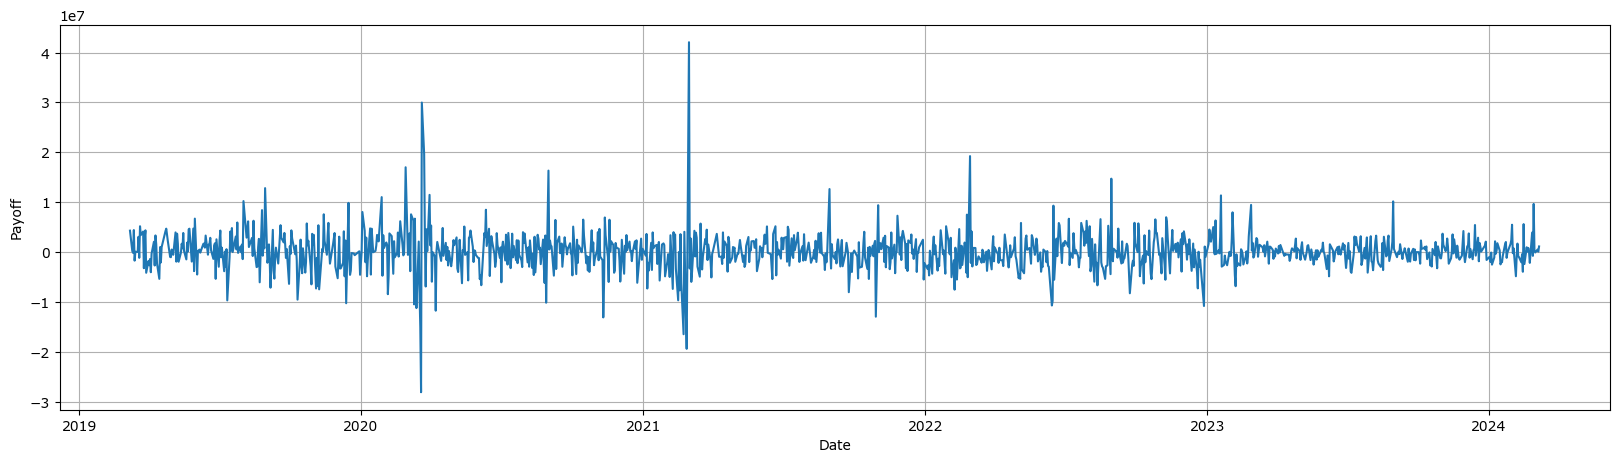

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

c/


MONTHLY CALCULATION


In [16]:
payoff, assessing_date = Question_3(True, 2, 3)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 310804.89304202795
Standard Deviation of payoff from rebalancing: 1544348.4775307758


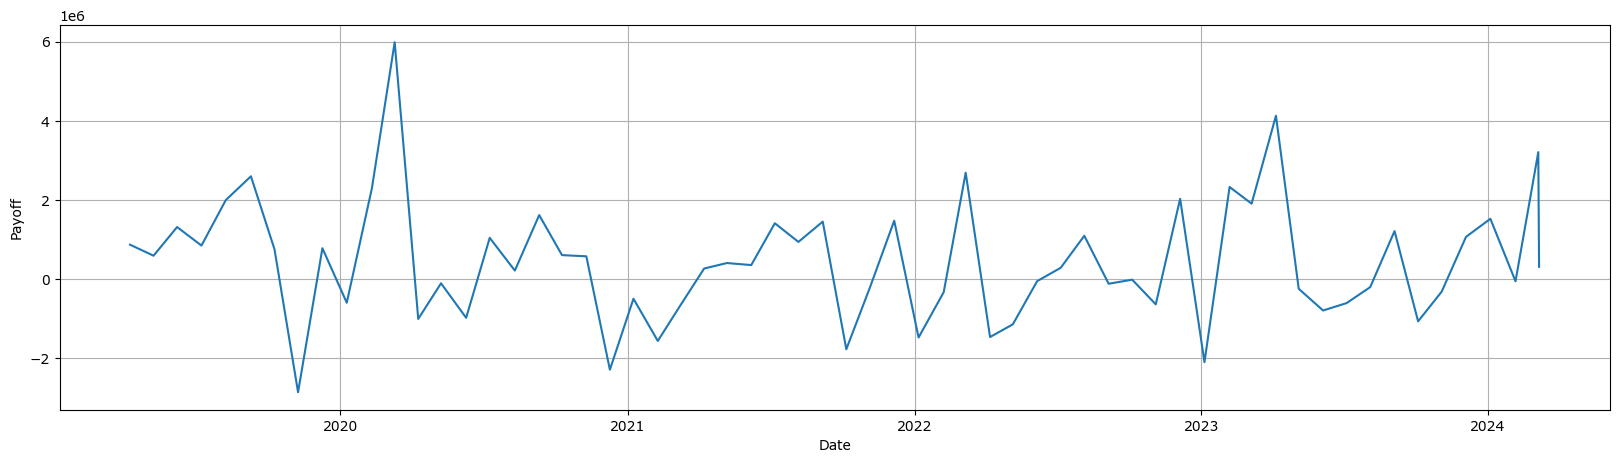

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

DAILY CALCULATION


In [18]:
payoff, assessing_date = Question_3(False, 2, 3)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 310804.89304202795
Standard Deviation of payoff from rebalancing: 445119.76776388026


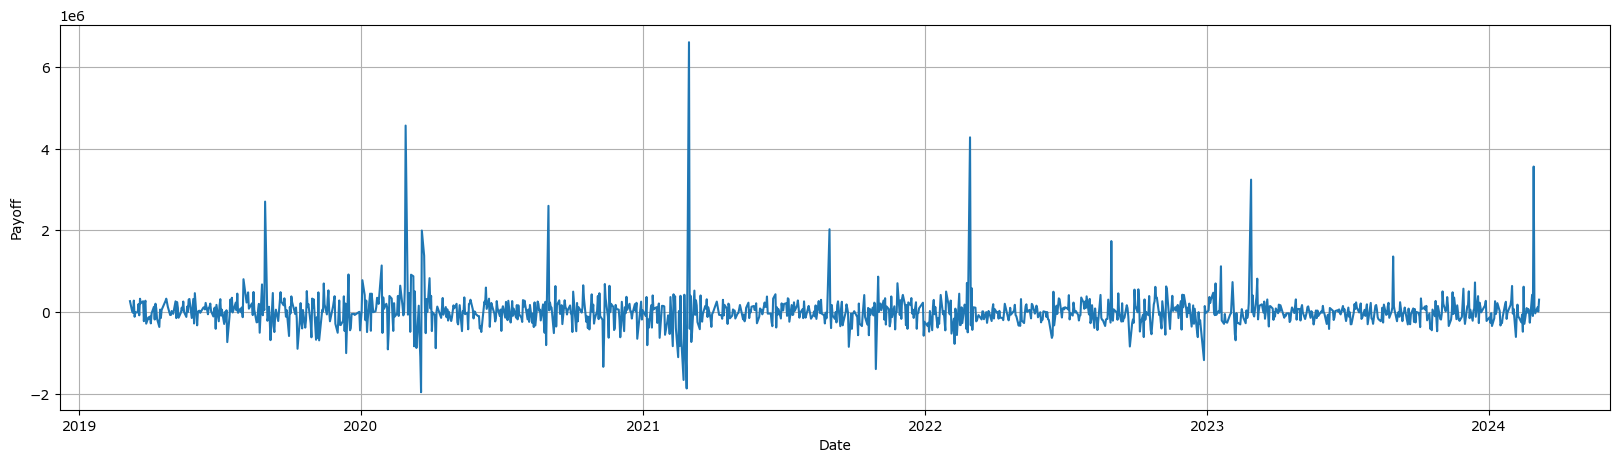

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

d/


MONTHLY CALCULATION


In [20]:
payoff, assessing_date = Question_3(True, 1, 2, 4)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 787226.5410911441
Standard Deviation of payoff from rebalancing: 454659824.6501734


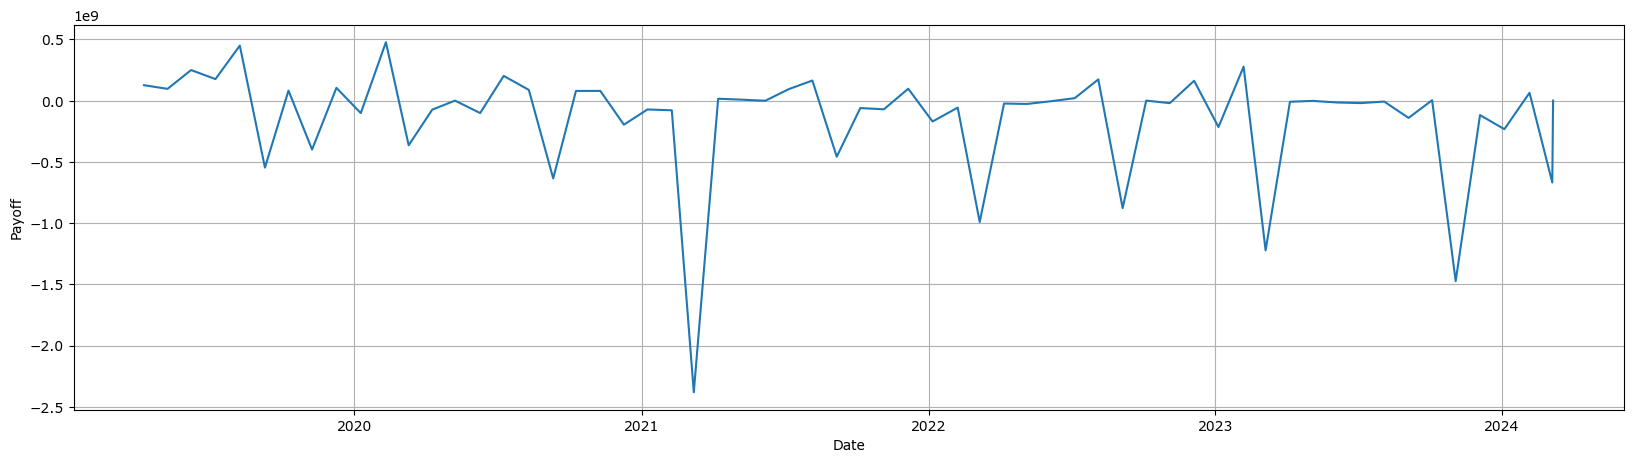

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

DAILY CALCULATION


In [22]:
payoff, assessing_date = Question_3(False, 1, 2, 4)
print("Payoff from rebalancing in 6/3/2024:", payoff[-1])
print("Standard Deviation of payoff from rebalancing:", np.std(payoff[1:]))

Payoff from rebalancing in 6/3/2024: 787226.5410911441
Standard Deviation of payoff from rebalancing: 50476351609.227646


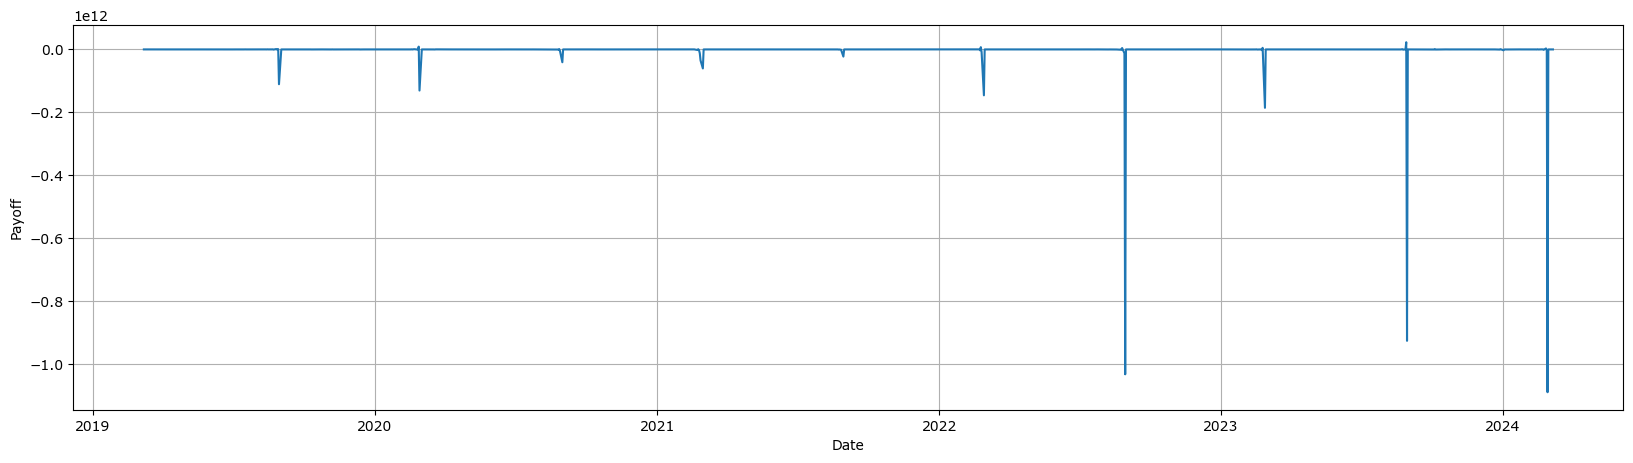

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(assessing_date[1:], payoff[1:])
plt.xlabel("Date")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()

e/

Sumarize and comparision:

- The standard deviation of the daily method is smaller than the monthly method's in portfolio consisting of bonds B1 and B4
- The standard deviation of the daily method is smaller than the monthly method's in portfolio consisting of bonds B2 and B3
- The standard deviation of the daily method is smaller than the monthly method's in portfolio consisting of bonds B1, B2 and B3
- The standard deviation of the daily method in portfolio consisting of bonds B1 and B4 is the smallest among the standard deviations
- The standard deviation of the monthly method in portfolio consisting of bonds B1, B2 and B4 is the largest among the standard deviations
- The payoff on the last date of assessment of the daily method is smaller than the monthly method's in portfolio consisting of bonds B1 and B4
- The payoff on the last date of assessment of the daily method is smaller than the monthly method's in portfolio consisting of bonds B2 and B3
- The payoff on the last date of assessment of the daily method is smaller than the monthly method's in portfolio consisting of bonds B1, B2 and B3
- The payoff on the last date of assessment of the daily method in portfolio consisting of bonds B1, B2 and B4 is the smallest among the payoff on the last date of assessments
- The payoff on the last date of assessment of the monthly method in portfolio consisting of bonds B1 and B4 is the largest among the payoff on the last date of assessments

Opinions:

- Due to having higher frequency of rebalancing, the daily method seems to have less fluctuation in the payoff
- Due to having more number of bond in the portfolio, the portfolio that has higher bonds seems to have more fluctuation in the payoff
- Due to having higher frequency of rebalancing, the daily method seems to have the payoff on the day of assessment closer to 0
- Due to having more number of bond in the portfolio, the portfolio that has higher bonds seems to have the payoff on the day of assessment further from 0
